# Constants

In [2]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1' # only relevant to my own environment

In [3]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

1.15.0
2.1.6


Using TensorFlow backend.


In [4]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]
MIDI_DRUM_MAP = {
   36: 0,
   35: 0,
   38: 1,
   27: 1,
   28: 1,
   31: 1,
   32: 1,
   33: 1,
   34: 1,
   37: 1,
   39: 1,
   40: 1,
   56: 1,
   65: 1,
   66: 1,
   75: 1,
   85: 1,
   42: 2,
   44: 2,
   54: 2,
   68: 2,
   69: 2,
   70: 2,
   71: 2,
   73: 2,
   78: 2,
   80: 2,
   46: 3,
   67: 3,
   72: 3,
   74: 3,
   79: 3,
   81: 3,
   45: 4,
   29: 4,
   41: 4,
   61: 4,
   64: 4,
   84: 4,
   48: 5,
   47: 5,
   60: 5,
   63: 5,
   77: 5,
   86: 5,
   87: 5,
   50: 6,
   30: 6,
   43: 6,
   62: 6,
   76: 6,
   83: 6,
   49: 7,
   55: 7,
   57: 7,
   58: 7,
   51: 8,
   52: 8,
   53: 8,
   59: 8,
   82: 8
}

DRUM_MIDI_MAP = [ # pianoroll to MIDI - reverse
    36, # 0 Kick
    38, # 1 Snare
    42, # 2 Hihat Closed
    46, # 3 Hihat Open
    45, # 4 Tom Low
    47, # 5 Tom Mid
    50, # 6 Tom High
    49, # 7 Clap
    51  # 8 Rim
]

resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


# Training

In [5]:
import numpy as np

# load pianoroll matrix - see "0_preprocess_midi.ipynb"

matrices_drums = np.load("./tmp/matrices_drum_gm_electronic.npz")['drum_data']
matrices_genres = np.load("./tmp/matrices_drum_gm_electronic.npz")['genre_ids']
matrices_times = np.load("./tmp/matrices_drum_gm_electronic.npz")['timeshift']
GENRES_ALL = np.load("./tmp/matrices_drum_gm_electronic.npz")['genres']

print(GENRES_ALL)
print(matrices_genres.shape)

# Filter genres 
GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
NB_GENRES = len(GENRES)

print(GENRES_ID_USED)
print(NB_GENRES, GENRES)

_drums = []
_genres = []

for genre_id, drum in zip(matrices_genres, matrices_drums):
    if genre_id in GENRES_ID_USED:
        _drums.append(drum)
        genre_id = GENRES_ID_USED.index(genre_id)
        _genres.append(genre_id)

matrices_drums = np.array(_drums)
print(matrices_drums.shape)
matrices_genres = np.array(_genres)
print(matrices_genres.shape)


['Old Skool' 'Trance' 'DnB' 'Basic' 'Downtempo' 'Jungle' 'House'
 'Breakbeat' 'Garage' 'Techno']
(49003,)
[0, 2, 5, 6, 7, 8, 9]
7 ['Old Skool', 'DnB', 'Jungle', 'House', 'Breakbeat', 'Garage', 'Techno']
(37950, 32, 9)
(37950,)


In [7]:
from keras.models import load_model
generator = load_model("./x-rhythm-can-models/c_generator-epoch-024-0.92261.h5")





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








/Users/nao/anaconda3/envs/p3/lib/python3.7/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       700         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_1

In [17]:
!pip install seaborn

     |████████████████████████████████| 225kB 2.9MB/s eta 0:00:01


In [92]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import random
#import pretty_midi
from IPython.display import Audio
from scipy.io import wavfile



# Create Z for generator
def get_noise(batch_size, len_input):
#    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, len_input])
    
    # better to use a spherical Z. according to https://github.com/soumith/ganhacks
    noise = np.random.normal(0.0, 0.50, size=[batch_size, len_input])
    return noise

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        
        fig = plt.figure(figsize=(12,5))
        ax = fig.add_subplot(111)
        ax.set_xticklabels(["1.1","1.2","1.3","1.4","2.1","2.2","2.3","2.4"] )
        ax.set_yticklabels([""]+DRUM_CLASSES)
        for i in range(8):
            plt.axvline(x=i*4-0.5,  color='0.7', linewidth=0.5)
        plt.axvline(x=15.5, color='0.5', linewidth=1.0)
        
        ax.matshow(a, cmap="Greys")
        plt.xticks(np.arange(0, 32, 4.0))
        plt.show()  
        
        
def play_drum_matrix(mat, tempo=120.0):
    # generate audio
    audio_data = get_audio_from_drum_matrix(mat, tempo=tempo)
    display(Audio(audio_data, rate=44100))
    return audio_data

def get_audio_from_drum_matrix(mat, tempo=120.):
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo) # midi object
    pm_inst = pretty_midi.Instrument(0, is_drum=True) # midi instrument
    
    timestep = (60./tempo) / 4. # duration of a 16th note
    for position, timeslot in enumerate(mat):
        for inst, onset in enumerate(timeslot):
            if onset > 0.:
                note_number = DRUM_MIDI_MAP[inst]
                velocity = int(onset * 127.)
                start = timestep * position
                end = timestep * (position + 0.5)
                
                # create a midi note
                note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
                pm_inst.notes.append(note)
    pm.instruments.append(pm_inst)

    # midi -> audio
    audio_data = pm.fluidsynth()
    return audio_data

[[3]] House


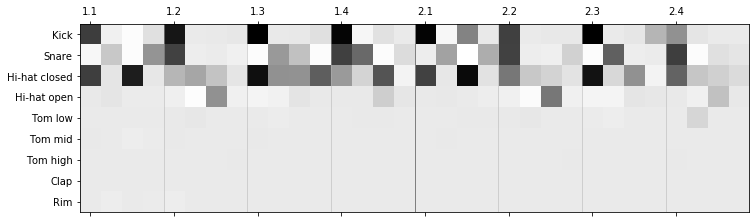

[[5]] Garage


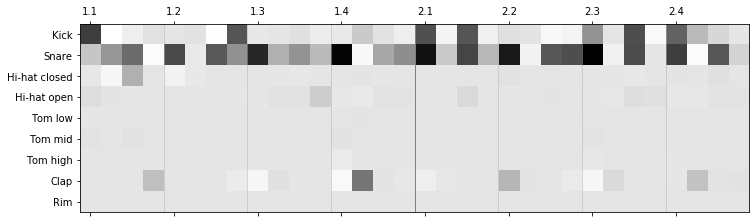

[[2]] Jungle


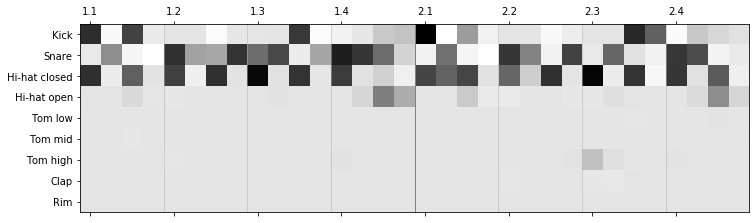

[[1]] DnB


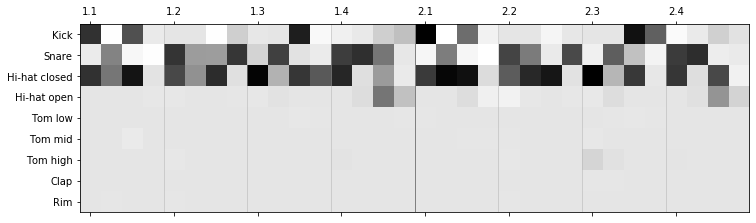

[[0]] Old Skool


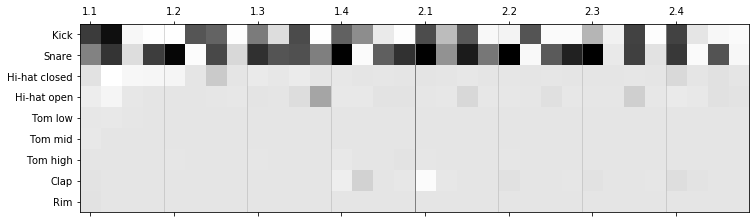

[[4]] Breakbeat


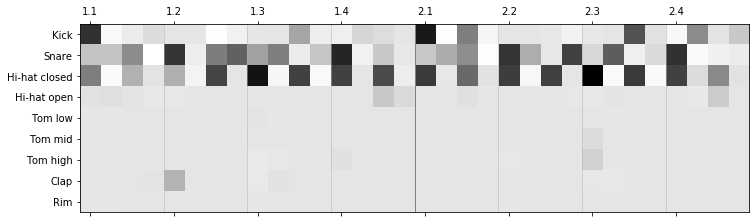

[[0]] Old Skool


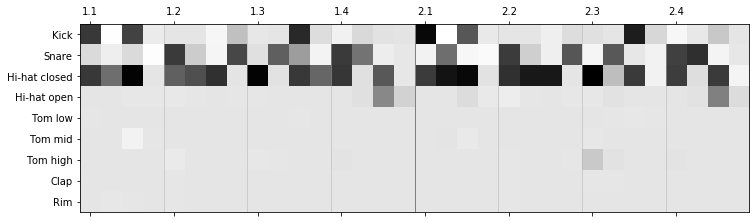

[[4]] Breakbeat


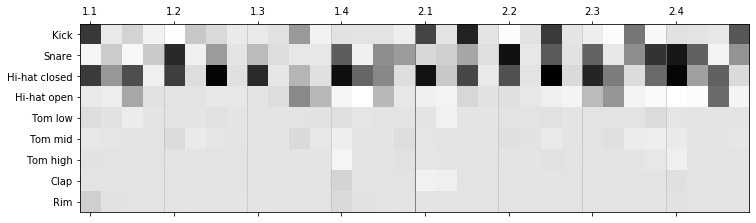

[[0]] Old Skool


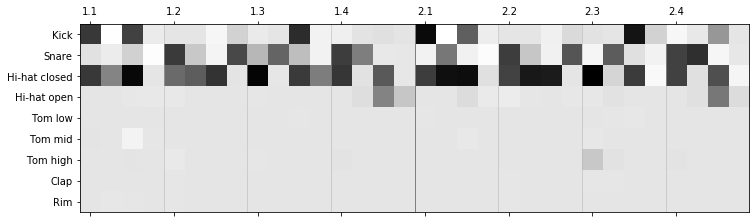

[[2]] Jungle


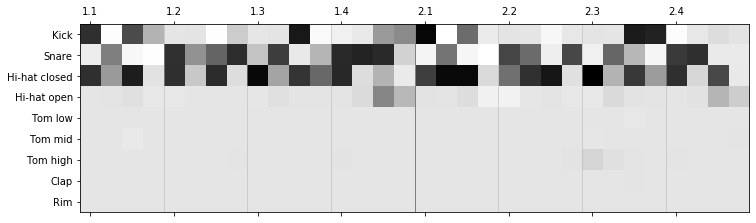

In [93]:
import pretty_midi
import seaborn

len_input = 100

for i in range(10):
#     noise = get_noise(1, len_input)
#     drum_generated = generator.predict(noise)
#     plot_drum_matrix(drum_generated)
    
        # sample output
    noise = get_noise(1, len_input)
    labels_random = np.random.randint(0, NB_GENRES, 1).reshape(-1, 1)
    drum_generated = generator.predict([noise, labels_random])

    genre = GENRES[int(labels_random)]
    print (labels_random, genre)
    plot_drum_matrix(drum_generated)

    # sample audio output
    play_drum_matrix(np.squeeze(drum_generated))
#     wavfile.write("c_drum_%s_%05d_%05d.wav" % (genre, epoch, repeat), 44100, audio_data)